#### E23 Recommend Movie

In [36]:
import os
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import datetime

#### 1. 데이터 불러오기

In [60]:
data_path = Path(os.getenv('HOME') + '/aiffel/yoochoose-data/ml-1m')
train_path = data_path/'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


#### 2. 데이터 전처리

In [61]:
print(f'UserId : {data["UserId"].nunique()} Items : {data["ItemId"].nunique()}')

UserId : 6040 Items : 3706


위에서 UserID는 사용자로 생각을 하고 따라서 각 사용자가 영화를 몇편을 보고 평가를 하였는지로 생각할 수 있다.

In [62]:
userid_length = data.groupby('UserId').size()
userid_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

UserId로 묶어 숫자를 세어보면 해당 user가 몇편의 영화를 보고 평가를 하였는지 알 수 있다. 

In [63]:
data[data['UserId'] == 1]['Time'].nunique()

34

UserId가 1인 user의 갯수는 53개였는데 중복되는 시간을 제외하면 34로 줄어드는 것으로 보아 시간의 순서는 큰 영향이 없고 단지 영화를 평가한 시간만을 확인할 수 있는 것으로 생각되어 제외하는 것이 더 좋을 것이라고 생각한다.

In [64]:
data = data.iloc[:, 0:3]
data

,UserId,ItemId,Rating
31,1,3186,4
22,1,1270,5
27,1,1721,4
37,1,1022,5
24,1,2340,3
...,...,...,...
1000019,6040,2917,4
999988,6040,1921,4
1000172,6040,1784,3
1000167,6040,161,3


In [65]:
userid_length.median(), userid_length.mean()

(96.0, 165.5975165562914)

In [66]:
userid_length.min(), userid_length.max()

(20, 2314)

가장 많은 영화를 본 user는 2314편의 영화를 보고 평가하였다. 

In [67]:
userid_length.quantile(0.999)

1343.181000000005

대부분의 user는 1343편 아래로 영화를 감상하였는 걸 알 수 있고 따라서 2314편의 영화를 본 user는 비정상적인 데이터로 판단될 가능성도 있다고 생각 한다. 

In [68]:
long_userid = userid_length[userid_length==2314].index[0]
data[data['UserId'] == long_userid]

,UserId,ItemId,Rating
696969,4169,1268,5
697168,4169,2617,4
697185,4169,2628,4
697219,4169,2653,4
697275,4169,423,3
...,...,...,...
697882,4169,3754,2
695702,4169,1413,3
697358,4169,494,4
695945,4169,1804,2


In [69]:
length_count = userid_length.groupby(userid_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

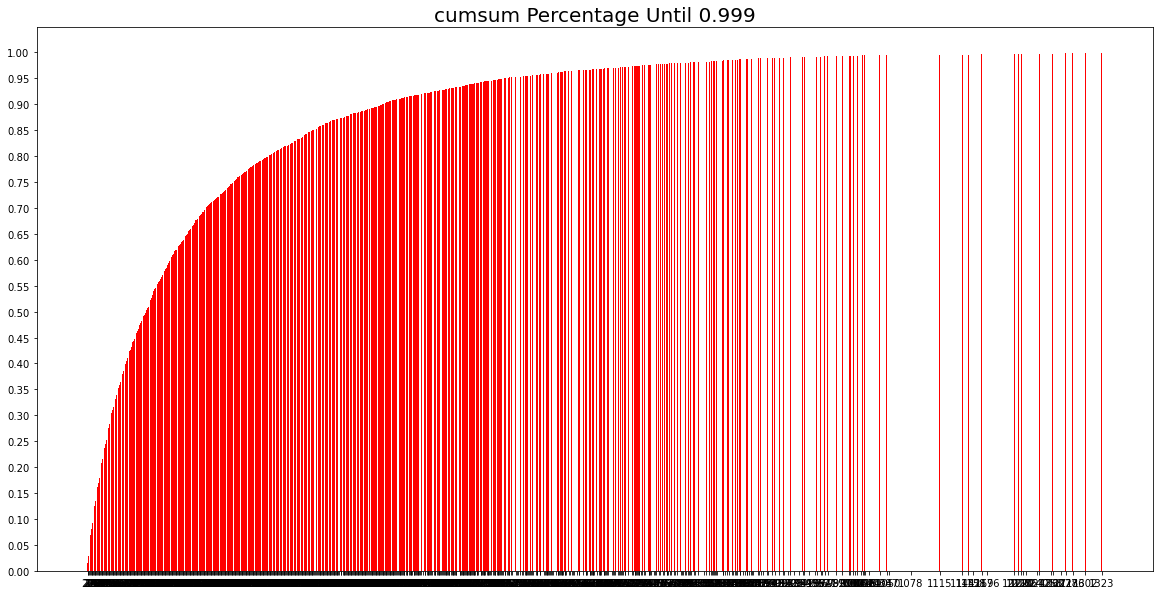

In [70]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index, height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('cumsum Percentage Until 0.999', size=20)
plt.show()

month_ago = latest - dt.timedelta(30)
data = data[data['Time'] > month_ago]
data

- Rating 점수가 2이하인 경우는 영화를 추천하지 않을 것으로 판단되어 Rating이 2이하인 경우는 제외하여 준다. 

In [71]:
def cleanse_recursive(data:pd.DataFrame, lowrate) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_low_rate_session(data, lowrate)
        after_len = len(data)
        if before_len == after_len:
            break
        return data
    
def cleanse_low_rate_session(data: pd.DataFrame, lowrate):
    
    rate_use = data[data['Rating'] > lowrate].index
    data = data[data['UserId'].isin(rate_use)]
    return data


In [72]:
data = cleanse_recursive(data, lowrate=2)
data

,UserId,ItemId,Rating
31,1,3186,4
22,1,1270,5
27,1,1721,4
37,1,1022,5
24,1,2340,3
...,...,...,...
1000019,6040,2917,4
999988,6040,1921,4
1000172,6040,1784,3
1000167,6040,161,3


In [48]:
# def split_by_date(data: pd.DataFrame, n_days:int):
#     final_time = data['Time'].max()
#     session_last_time = data.groupby('SessionId')['Time'].max()
#     session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
#     session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index
    
#     before_date = data[data['SessionId'].isin(session_in_train)]
#     after_date = data[data['SessionId'].isin(session_in_test)]
#     after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    
#     return before_date, after_date

In [49]:
# tr, test = split_by_date(data, n_days=1)
# tr, val = split_by_date(tr, n_days=1)

In [50]:
# def stats_info(data: pd.DataFrame, status: str):
#     print(f'* {status} Set Stats Info\n'
#           f'\t Events: {len(data)}\n'
#           f'\t Sessions: {data["SessionId"].nunique()}\n'
#           f'\t Items: {data["ItemId"].nunique()}\n'
#           f'\t First Time : {data["Time"].min()}\n'
#           f'\t Last Time : {data["Time"].max()}\n')

In [51]:
# stats_info(tr, 'train')
# stats_info(val, 'valid')
# stats_info(test, 'test')

* train Set Stats Info
	 Events: 5125204
	 Sessions: 1243517
	 Items: 20158
	 First Time : 2014-08-31 03:00:01.111000+00:00
	 Last Time : 2014-09-28 02:57:34.348000+00:00

* valid Set Stats Info
	 Events: 58075
	 Sessions: 12351
	 Items: 6233
	 First Time : 2014-09-28 03:00:25.298000+00:00
	 Last Time : 2014-09-29 02:58:27.660000+00:00

* test Set Stats Info
	 Events: 71010
	 Sessions: 15290
	 Items: 6580
	 First Time : 2014-09-29 02:37:20.695000+00:00
	 Last Time : 2014-09-30 02:59:59.430000+00:00



In [52]:
# id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

# def indexing(df, id2idx):
#     df['item_idx'] = df['ItemId'].map(lambda x:id2idx.get(x, -1))
#     return df

# tr = indexing(tr, id2idx)
# val = indexing(val, id2idx)
# test = indexing(test, id2idx)

In [53]:
# save_path = data_path / 'processed'
# save_path.mkdir(parents=True, exist_ok=True)

# tr.to_pickle(save_path/'train.pkl')
# val.to_pickle(save_path/'valid.pkl')
# test.to_pickle(save_path/'test.pkl')

In [55]:
# class SessionDataset:
#     """Credit to yhs-968/pyGRU4REC."""
    
#     def __init__(self, data):
#         self.df = data
#         self.click_offsets = self.get_click_offsets()
#         self.session_idx = np.arange(self.df['SessionId'].nunique())
        
#     def get_click_offsets(self):
        
#         offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
#         offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        
#         return offsets

In [56]:
# tr_dataset = SessionDataset(tr)
# tr_dataset.df.head(10)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [57]:
# tr_dataset.click_offsets

array([      0,       4,       6, ..., 5125199, 5125201, 5125204],
      dtype=int32)

In [58]:
# tr_dataset.session_idx

array([      0,       1,       2, ..., 1243514, 1243515, 1243516])

In [60]:
# class SessionDataLoader:
    
#     def __init__(self, dataset: SessionDataset, batch_size=50):
#         self.dataset = dataset
#         self.batch_size = batch_size
        
#     def __iter__(self):
#         """ Returns the iterator for producing session-parallel training mini-batches.
#         Yields:
#             input (B,):  Item indices that will be encoded as one-hot vectors later.
#             target (B,): a Variable that stores the target item indices
#             masks: Numpy array indicating the positions of the sessions to be terminated
#         """
        
#         start, end, mask, last_session, finished = self.initialize()
        
#         """
#         start : Index Where Session Start
#         end : Index Where Session End
#         mask : indicator for the sessions to be terminated
#         """
        
#         while not finished:
#             min_len = (end - start).min() - 1
#             for i in range(min_len):
                
#                 inp = self.dataset.df['item_idx'].values[start + i]
#                 target = self.dataset.df['item_idx'].values[start + i + 1]
#                 yield inp, target, mask
                
#             start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)
            
#     def initialize(self):
#         first_iters = np.arange(self.batch_size)
#         last_session = self.batch_size - 1
#         start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]
#         end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]
#         mask = np.array([])
#         finished = False
#         return start, end, mask, last_session, finished
    
#     def update_status(self, start: np.ndarray, end: np.ndarray, min_len:int, last_session:int, finished: bool):
        
#         start += min_len
#         mask = np.arange(self.batch_size)[(end - start) == 1]
        
#         for i, idx in enumerate(mask, start=1):
#             new_session = last_session + i
#             if new_session > self.dataset.session_idx[-1]:
#                 finished = True
#                 break
                
#             start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]
#             end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]
            
#         last_session += len(mask)
#         return start, end, mask, last_session, finished

In [61]:
# tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
# tr_dataset.df.head(15)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [62]:
# iter_ex = iter(tr_data_loader)

In [63]:
# inputs, labels, mask =  next(iter_ex)
# print(f'Model Input Item Idx are : {inputs}')
# print(f'Label Item Idx are : {"":5} {labels}')
# print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 3 5 7]
Label Item Idx are :       [1 4 6 7]
Previous Masked Input Idx are []


In [64]:
# def mrr_k(pred, truth: int, k: int):
#     indexing = np.where(pred[:k] == truth)[0]
#     if len(indexing) > 0:
#         return 1 / (indexing[0] + 1)
#     else: 
#         return 0
    
# def recall_k(pred, truth:int, k: int) -> int:
#     answer = truth in pred[:k]
#     return int(answer)

In [65]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense, Dropout, GRU
# from tensorflow.keras.losses import categorical_crossentropy
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import to_categorical
# from tqdm import tqdm

In [68]:
# def create_model(args):
    
#     inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
#     gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
#     dropout = Dropout(args.drop_rate)(gru)
#     predictions = Dense(args.num_items, activation='softmax')(dropout)
#     model = Model(inputs=inputs, outputs=[predictions])
#     model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
#     model.summary()
    
#     return model

In [70]:
# class Args:
#     def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        
#         self.tr = tr
#         self.val = val
#         self.test = test
#         self.num_items = tr['ItemId'].nunique()
#         self.num_sessions = tr['SessionId'].nunique()
#         self.batch_size = batch_size
#         self.hsz = hsz
#         self.drop_rate = drop_rate
#         self.lr = lr
#         self.epochs = epochs
#         self.k = k

# args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [71]:
# model = create_model(args)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 20158)]        0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  3031500   
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 20158)             1028058   
Total params: 4,059,558
Trainable params: 4,059,558
Non-trainable params: 0
_________________________________________________________________


In [78]:
# def train_model(model, args):
#     train_dataset = SessionDataset(args.tr)
#     train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)
    
#     for epoch in range(1, args.epochs + 1):
#         total_step = len(args.tr) - args.tr['SessionId'].nunique()
#         tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
#         for feat, target, mask in tr_loader:
#             reset_hidden_states(model, mask)
            
#             input_ohe = to_categorical(feat, num_classes=args.num_items)
#             input_ohe = np.expand_dims(input_ohe, axis=1)
#             target_ohe = to_categorical(target, num_classes=args.num_items)
            
#             result = model.train_on_batch(input_ohe, target_ohe)
#             tr_loader.set_postfix(train_loss=result[0], accuracy=result[1])
            
#         val_recall, val_mrr = get_metrics(args.val, model, args, args.k)
        
#         print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
#         print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")
        
# def reset_hidden_states(model, mask):
#     gru_layer = model.get_layer(name='GRU')
#     hidden_states = gru_layer.states[0].numpy()
#     for elt in mask:
#         hidden_states[elt, :] = 0
#     gru_layer.reset_states(states=hidden_states)
    
# def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
#                                              # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
#     dataset = SessionDataset(data)
#     loader = SessionDataLoader(dataset, batch_size=args.batch_size)
#     recall_list, mrr_list = [], []

#     total_step = len(data) - data['SessionId'].nunique()
#     for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
#         reset_hidden_states(model, mask)
#         input_ohe = to_categorical(inputs, num_classes=args.num_items)
#         input_ohe = np.expand_dims(input_ohe, axis=1)

#         pred = model.predict(input_ohe, batch_size=args.batch_size)
#         pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

#         length = len(inputs)
#         recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
#         mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

#     recall, mrr = np.mean(recall_list), np.mean(mrr_list)
#     return recall, mrr

In [79]:
# train_model(model, args)

Train:   0%|          | 0/1895 [00:00<?, ?it/s]

	 - Recall@20 epoch 1: 0.451947
	 - MRR@20    epoch 1: 0.168577



Train:  12%|█▏        | 220/1895 [01:29<11:20,  2.46it/s, accuracy=0.0913, train_loss=5.68]


KeyboardInterrupt: 

In [ ]:
# def test_model(model, args, test):
#     test_recall, test_mrr = get_metrics(test, model, args, 20)
#     print(f"\t - Recall@{args.k}: {test_recall:3f}")
#     print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

# test_model(model, args, test)

#### 3. 고찰
- 기존 프로젝트에서는 시간 순서에 따라 클릭한 상품에 대한 정보를 가지고 모델을 학습하고 예측을 하여 주었는데 영화 데이터의 경우에는 시간순서로 영화를 본 것이 아닌 중복된 시간이 존재하는 것으로 보아 해당 시간에 영화에 대한 평가를 한 것이라 판단되어 이러한 경우에는 Sequential한 정보가 없어 동일한 모델로 학습을 시키는 것이 의미가 없을 것이라고 판단하였습니다. 
- 프로젝트에 대한 이해가 부족하여 데이터를 변경한 경우 정상적으로 프로젝트 진행이 불가능하여 중단하였습니다.
- 이후 다시 프로젝트를 공부하고 진행할 예정입니다.